# Novel Time Series Primitive that Allows Real World Classification

## Contrast Profile

The tutorial is adapted from the [Matrix Profile XXIII paper](https://www.cs.ucr.edu/~eamonn/ContrastProfile_V048_names.pdf).  

Subsequence’s distance to its nearest neighbor within the same 
dataset can be represented by the [Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html).  

Time series **motifs** refer to two particularly **close** subsequences,  
whereas time series **discords** indicate subsequences that are **far** from their nearest neighbors (**anomaly**).  

If a dataset has two similar subsequences that are far from the rest of subsequences, they may not be discovered as motif or discord by matrix profile.

Let's demonstrate it with ECG data in followoing condition .  
[1]. Matrix Profile on the first half of dataset which has **1 anomaly**.  
[2]. Matrix Profile on whole dataset which has **2 similar anomalies**.

In [1]:
import stumpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

df = pd.read_csv("ECG_demo.csv", index_col=0).astype(float)
T = df.values[:, 1]  # with 2 similar anomalies
m = 128  # window size as an example

Let's see the entire dataset first.

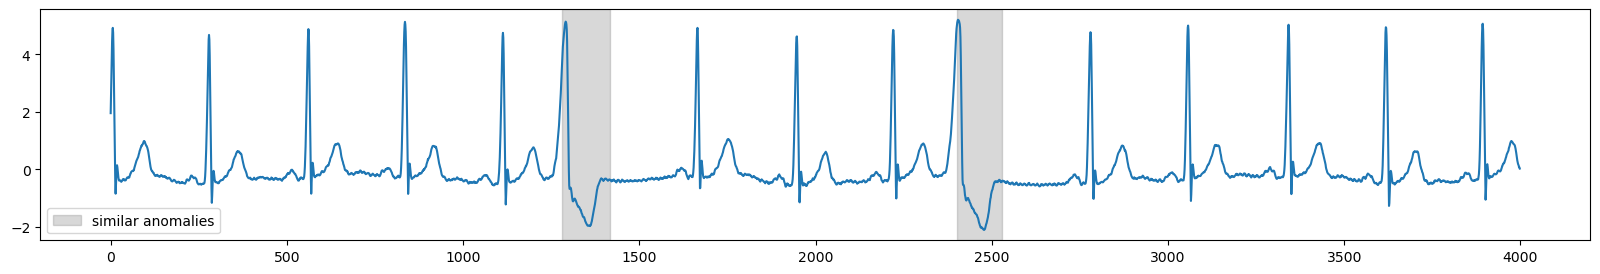

In [2]:
plt.figure(figsize=(20, 3))
plt.plot(T)
plt.axvspan(1280, 1290+m, color="grey", alpha=0.3, label="similar anomalies")
plt.axvspan(2400, 2400+m, color="grey", alpha=0.3)
plt.legend()
plt.show()

You can see two smilar anomalies. Those are targets we try to find.
##### [1]. Matrix Profile with **the first half** of dataset (which has 1 anomaly behavior.)

In [3]:
mp = stumpy.stump(T[:2000], m, normalize=False)
discord_idx = np.argmax(mp[:, 0])  # discord's index
discord_nn_idx = mp[discord_idx, 1]  # discord's nearest neighborhood index

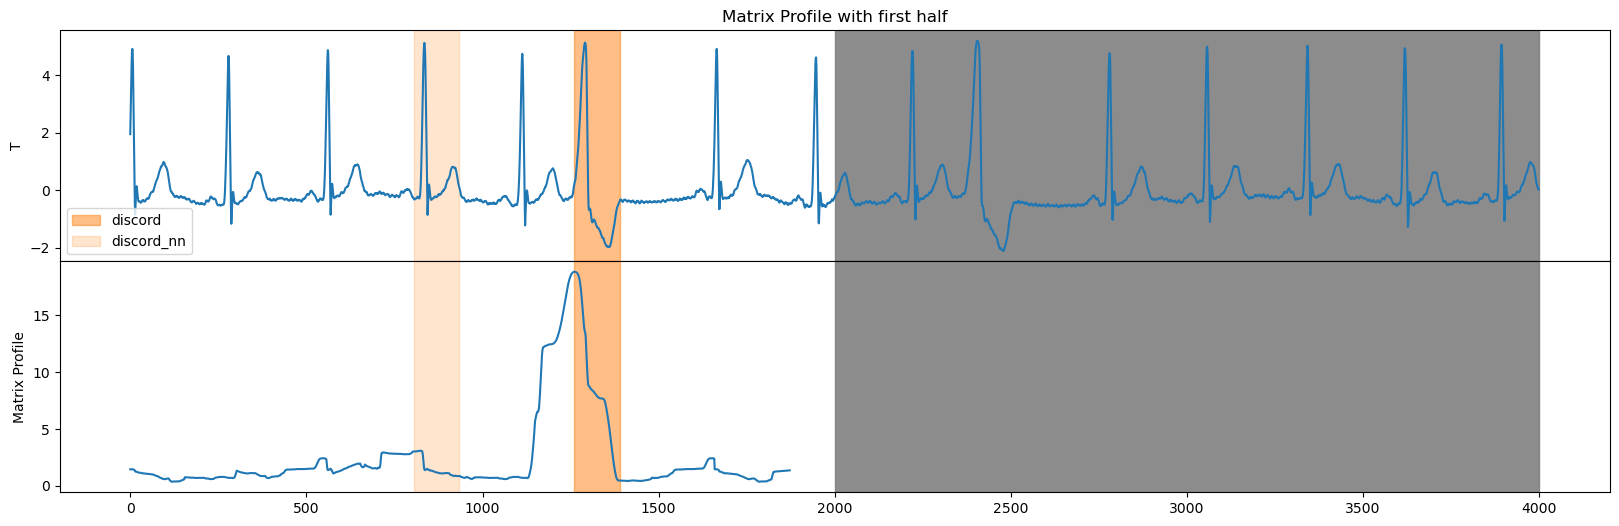

In [4]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(2000, 4000, color="grey", alpha=0.9)
axes[0].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[0].plot(T)
axes[1].axvspan(2000, 4000, color="grey", alpha=0.9)
axes[1].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[1].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[1].plot(mp[:, 0])
axes[0].legend()
axes[0].set_title("Matrix Profile with first half")
axes[0].set_ylabel("T")
axes[1].set_ylabel("Matrix Profile")
plt.show()

In this case, the discord, indicated by matrix profile, is what we are looking for.
##### [2].  Matrix Profile with **whole dataset** (which has 2 anomaly behaviors.)

In [14]:
mp = stumpy.stump(T, m, normalize=False)
discord_idx = np.argmax(mp[:, 0])  # discords index
discord_nn_idx = mp[discord_idx, 1]  # discords nearest neighborhood index

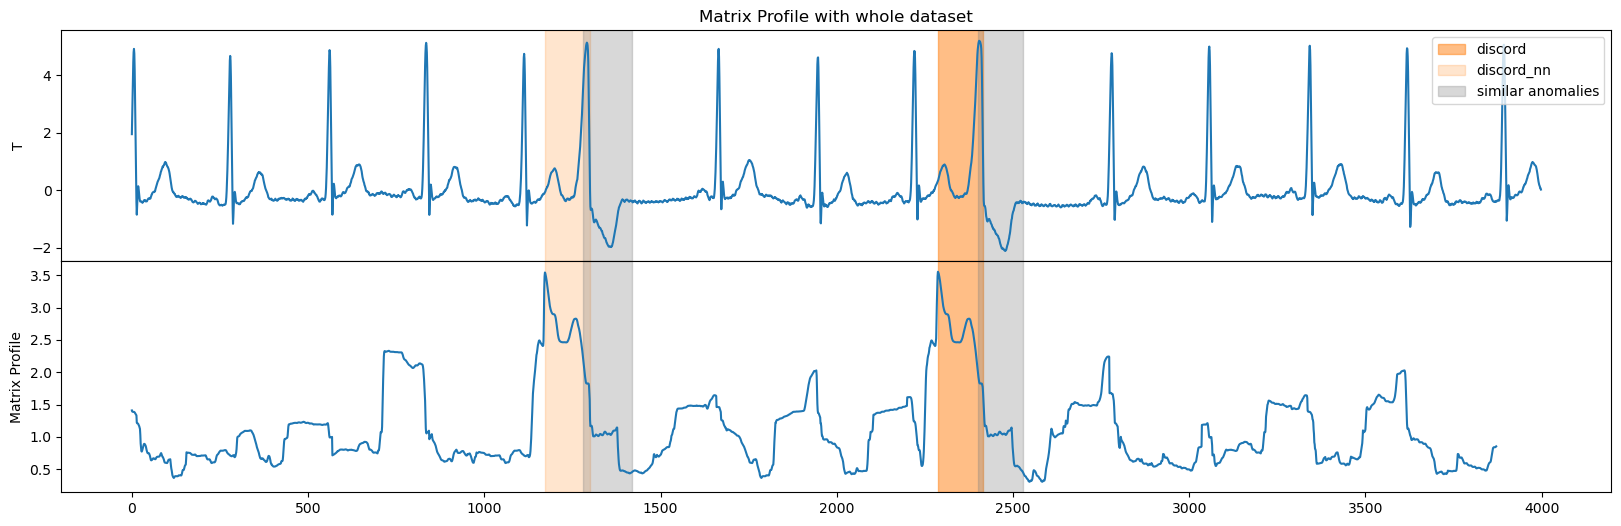

In [15]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[0].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="similar anomalies")
axes[0].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[0].plot(T)
axes[1].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5)
axes[1].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2)
axes[1].axvspan(1280, 1290+m, color="grey", alpha=0.3)
axes[1].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[1].plot(mp[:, 0])
axes[0].legend()
axes[0].set_title("Matrix Profile with whole dataset")
axes[0].set_ylabel("T")
axes[1].set_ylabel("Matrix Profile")
plt.show()

The discord discovered by matrix profile is not what are looking for.  
Because the targets we are looking for are similar to each other,   
they can be nearest neighbor of each other and hence their corresponding distance in matrix profile will be small.  
Therefore, none of them will be detected via matrix profile

To find the desirable anomalies, we should first understand what properties distinguish them from the other patterns.  
- These two anomalies are similar to each other.
- They are dissimmilar to other (regular) patterns.

We call these type of discoreds property (our interest) **Contrast**, and the vector that represents it the **Contrast Profile**.  
This is the main concept behind the contrast matrix profile.  

## Contrast Profile
To compute the contrast matrix profile, two time series data are needed as follows:
- **𝐓(+)**: contains  **at  least  two  instances**  that  are  unique  to the phenomena of interest. (It also include regular, obvious patterns.)
- **𝐓(−)**: contains **zero instances of interest**.  


We call these type of discoreds property (our interest) **Contrast**, and the vector that represents it the **Contrast Profile**.  

## Loading the ECG data for Contrast Profile

We load two snippet T_pos: **T(+)** and T_neg: **T(-)**, Those are around 27-second snippet.  

In [16]:
ecg_df = pd.read_csv("ECG.csv", index_col=0).astype(float)
ecg_df.head(2)

,T(-),T(+)
0,30.0,-6.0
1,34.0,-8.0


In [17]:
T_n = ecg_df.iloc[:, 0].values  # T(-)
T_p = ecg_df.iloc[:, 1].values  # T(+)

m = 128

## Visualizing the ECG snippets with desired instances.
This dataset is ECG of 75-year-old male.  
According to the doctors that annotated this datasets, 
there are two examples of premature ventricular contractions, with start index of 580 and 2030 (see figure below)..  
Those are the two instances we would like to discover.


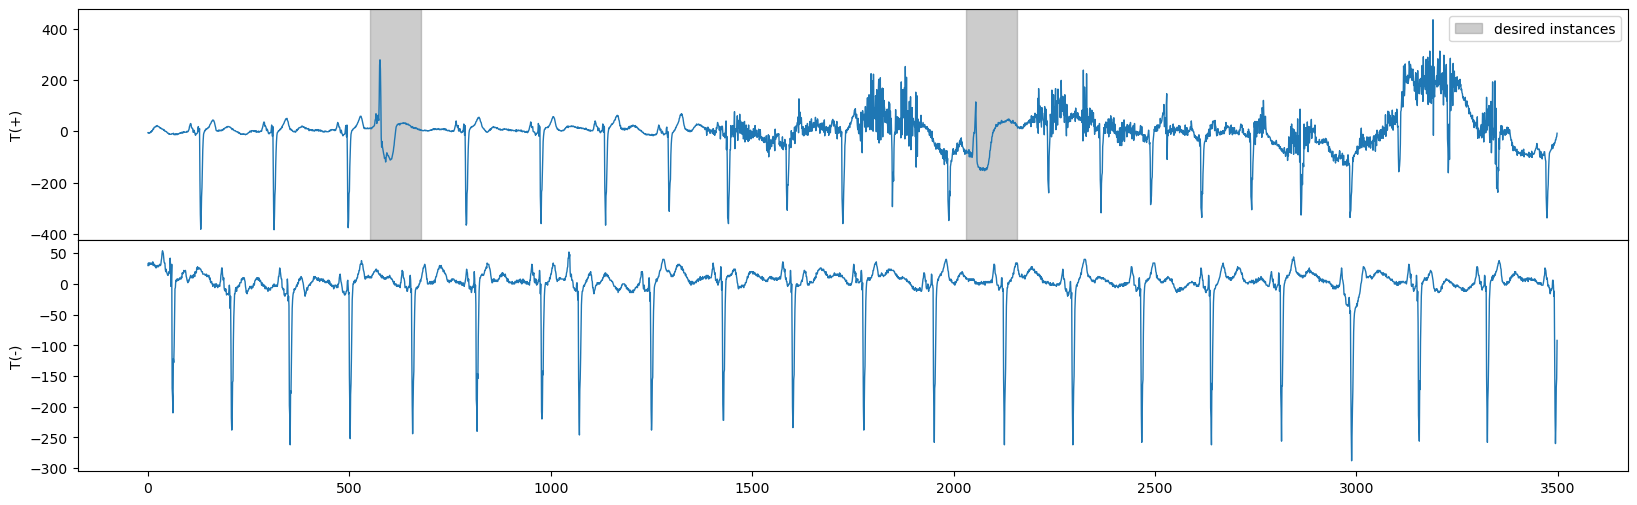

In [18]:
desired0_idx, desired1_idx = 550, 2030

fig, axes = plt.subplots(2, 1, gridspec_kw={"hspace":0})
axes[0].plot(T_p, linewidth=1)
axes[1].plot(T_n, linewidth=1)
axes[0].axvspan(desired0_idx, desired0_idx+m, color="grey", alpha=0.4, label="desired instances")
axes[0].axvspan(desired1_idx, desired1_idx+m, color="grey", alpha=0.4)
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("T(-)")
axes[0].legend(loc=1)

plt.show()

[Top Fig] : T(+) contains at least two instances that are of our interest. Signals on grey area are two "desired instances" which are similar.  

[Bottom Fig] : T(-) looks clean, much more regular repeated pattern. Because T(-) has to be **zero instances of interest**.

## What can Matrix Profile(self-join) find?
Let's demonstrate which kind of motifs/discords self-join Matrix Profile for T(+) can find.

In [19]:
MP_PP = stumpy.stump(T_p, m)
motif_idx = np.argmin(MP_PP[:, 0])
motif_nn_idx = MP_PP[motif_idx, 1]  # idx of another motif of the pair
discord_idx = np.argmax(MP_PP[:, 0])
discord_nn_idx = MP_PP[discord_idx, 1]  # idx of another discords of the pair

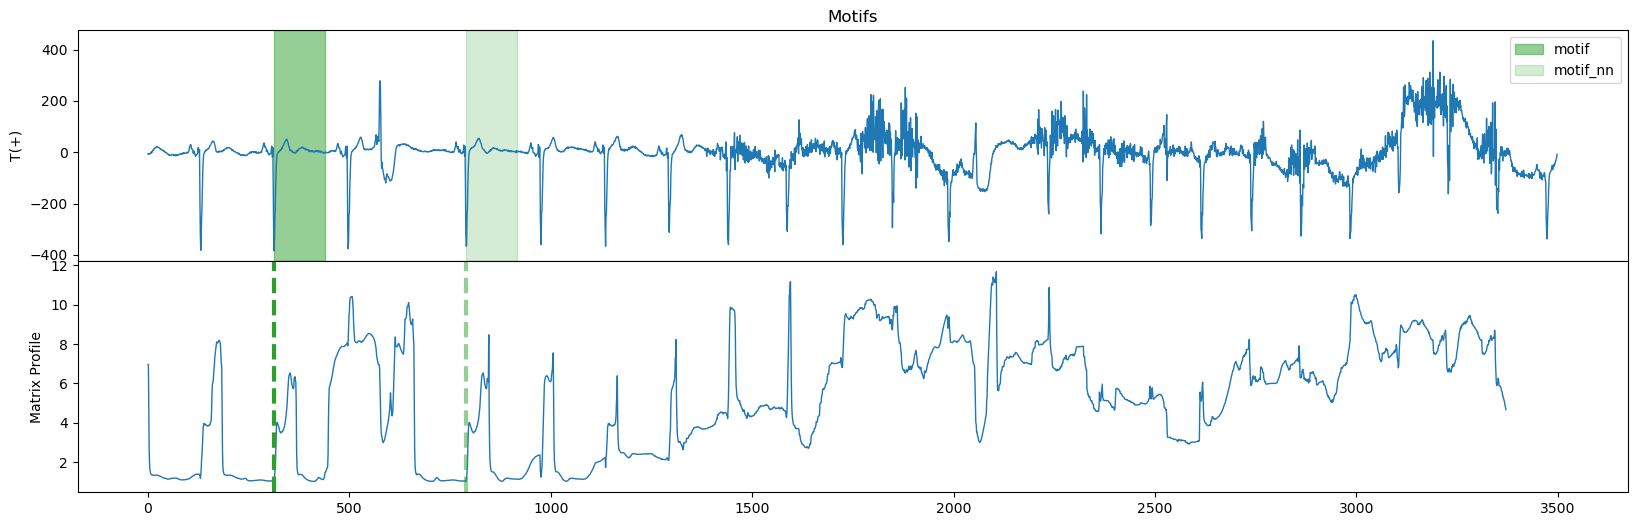

In [32]:
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
motif_style= {"color":"C2", "linestyle":"dashed", "linewidth": 3}

axes[0].plot(T_p, linewidth=1)
axes[1].plot(MP_PP[:, 0], linewidth=1)
axes[0].axvspan(motif_idx, motif_idx+m, color="C2", alpha=0.5, label="motif")
axes[1].axvline(motif_idx,  **motif_style)
axes[0].axvspan(motif_nn_idx, motif_nn_idx+m, color="C2", alpha=0.2, label="motif_nn")
axes[1].axvline(motif_nn_idx, alpha=0.5, **motif_style)
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("Matrix Profile")
axes[0].legend(loc=1)
axes[0].set_title("Motifs")
plt.show()

As shown in this figure, the motifs discovered by the matrix profile (of `T_p`) does not reveal our two desirble subsequences, the ones that were shown in the previous figure. 

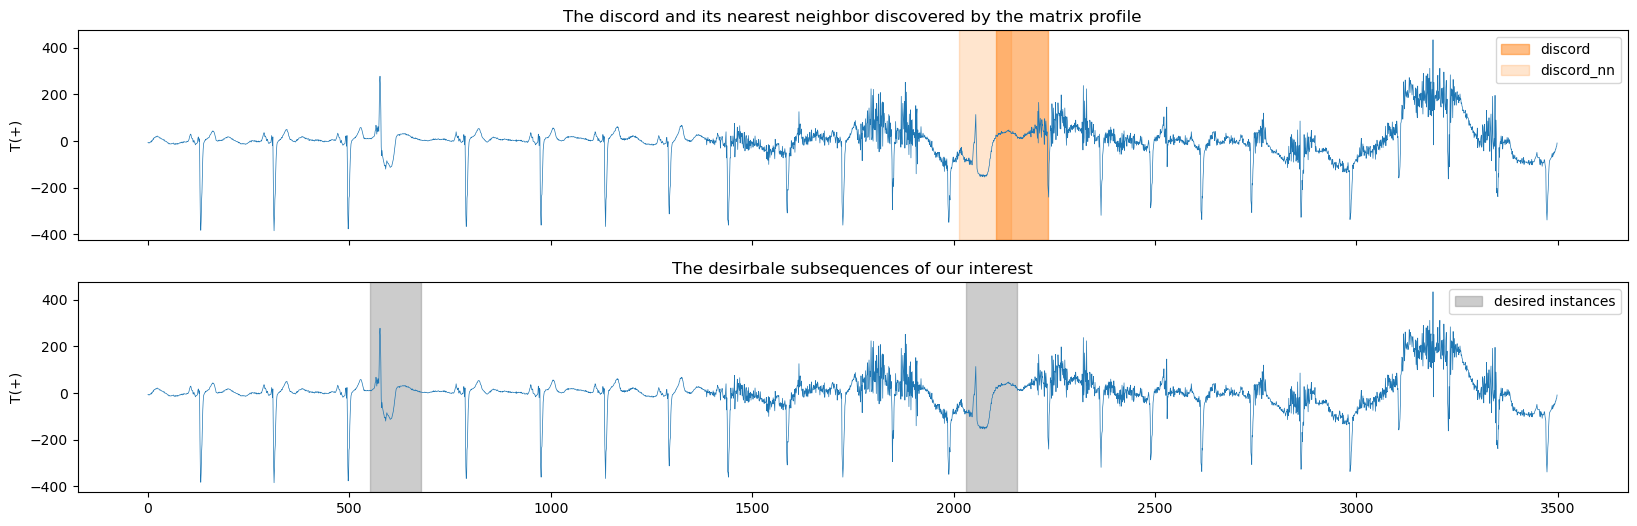

In [39]:
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.2}, figsize=(20, 6))
axes[0].plot(T_p, linewidth=0.5)
axes[1].plot(T_p, linewidth=0.5)

axes[0].axvspan(discord_idx, discord_idx+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx, discord_nn_idx+m, color="C1", alpha=0.2, label="discord_nn")
axes[1].axvspan(desired0_idx, desired0_idx+m, color="grey", alpha=0.4, label="desired instances")
axes[1].axvspan(desired1_idx, desired1_idx+m, color="grey", alpha=0.4)

axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("T(+)")
axes[0].set_title("The discord and its nearest neighbor discovered by the matrix profile")
axes[1].set_title("The desirbale subsequences of our interest")
axes[0].legend(loc=1)
axes[1].legend(loc=1)
plt.show()

These discords discovered by Matrix Profile is far different from desired instance.  
This phenomenon, as discussed above, is
Because the targets we are looking for are similar to each other,   
they can be nearest neighbor of each other and hence their corresponding distance in matrix profile will be small.  
Therefore, none of them will be detected via matrix profile